#### By: Peyman Shahidi
#### Created: Aug 21, 2025

<br>

In [1]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [2]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots"

In [3]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [4]:
# Read O*NET data
onet = pd.read_csv(f'{input_data_path}/onet_occupations_yearly.csv')

# keep 2023 entries only
onet = onet[onet['year'] == 2023].reset_index(drop=True)

# define industry column:
# 2-digit SOC code --> Major Group
# 5-digit SOC code --> Minor Group
# 6-digit SOC code --> Broad Occupation
# 7-digit SOC code --> Detailed Occupation
SOC_group_num_digits = 5
onet['ind'] = onet['occ_code'].apply(lambda x: x[:SOC_group_num_digits])

# remove 's for consistency issues 
onet = onet.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

In [5]:
def merge_SOC_titles(df, occupation_string):
    # Assume column occupation_string contains the string of occupation identifier in df

    occLength_SOCcolumn_mapping = {
        2: 'Major Group',
        5: 'Minor Group',
        6: 'Broad Occupation',
        7: 'Detailed Occupation'
    }

    industry_column_entry_length = len(df[occupation_string].iloc[0]) # take the length of first entry
    soc_col_name = occLength_SOCcolumn_mapping[industry_column_entry_length]

    # Read SOC groups and derive 2 digit codes (from https://www.onetcenter.org/taxonomy/2019/structure.html)
    soc_group_df = pd.read_csv(f'{input_data_path}/SOC_Structure.csv')
    soc_group_df = soc_group_df[[soc_col_name, 'SOC or O*NET-SOC 2019 Title']]
    soc_group_df = soc_group_df.rename(columns={soc_col_name: 'ind',
                                                'SOC or O*NET-SOC 2019 Title': 'ind_name'
                                                })

    # Prepare dataset for the merge
    soc_group_df = soc_group_df.dropna() # Drop rows with NaN in 'ind' or 'ind_name' -- has to be included due to structure of "SOC_Structure.csv"
    soc_group_df['ind'] = soc_group_df['ind'].apply(lambda x: x[:industry_column_entry_length])

    # Merge datasets
    merged_df = pd.merge(df, soc_group_df, left_on=occupation_string, right_on='ind', how='left')

    return merged_df

# Merge O*NET data with SOC titles
onet = merge_SOC_titles(onet, 'ind')

In [6]:
# remove duplicates
print(f"Number of rows before removing duplicates: {len(onet)}")
onet = onet.drop_duplicates(subset=['year', 'ind', 'occ_code', 'task_id']).reset_index(drop=True)
print(f"Number of rows after removing duplicates: {len(onet)}")


############################################################################################
################## There's a lot of duplicates that you have to look into ##################
############################################################################################

Number of rows before removing duplicates: 24426
Number of rows after removing duplicates: 19294


In [7]:
# # Remove rows where occupation title contains "All Other"
# onet = onet[~onet["occ_title"].str.contains("All Other", case=False, na=False)]

### Remove "Teachers"-related occupations

In [8]:
# Filter rows that contain "Teachers" (case-insensitive)
contains_teacher = onet[onet['occ_title'].str.contains('Teachers', case=False, na=False)]

# Step 2: Get the number of unique occupations containing "Teacher"
unique_teacher_occupations = contains_teacher['occ_title'].nunique()
print(f'Number of unique occupations containing the word "Teachers": {unique_teacher_occupations}')

# Remove rows that contain "Teacher" (case-insensitive)
onet = onet[~onet['occ_title'].str.contains('Teachers', case=False, na=False)].reset_index(drop=True)

Number of unique occupations containing the word "Teachers": 50


### Number of Unique Tasks / DWAs / WAs

In [9]:
# Number of unique tasks, DWAs, and WAs
num_unique_tasks = onet['task_id'].nunique()
num_unique_dwas = onet['dwa_id'].nunique()
num_unique_was = onet['wa_id'].nunique()

print(f"Number of unique tasks: {num_unique_tasks}")
print(f"Number of unique DWAs: {num_unique_dwas}")
print(f"Number of unique WAs: {num_unique_was}")

Number of unique tasks: 17945
Number of unique DWAs: 2067
Number of unique WAs: 37


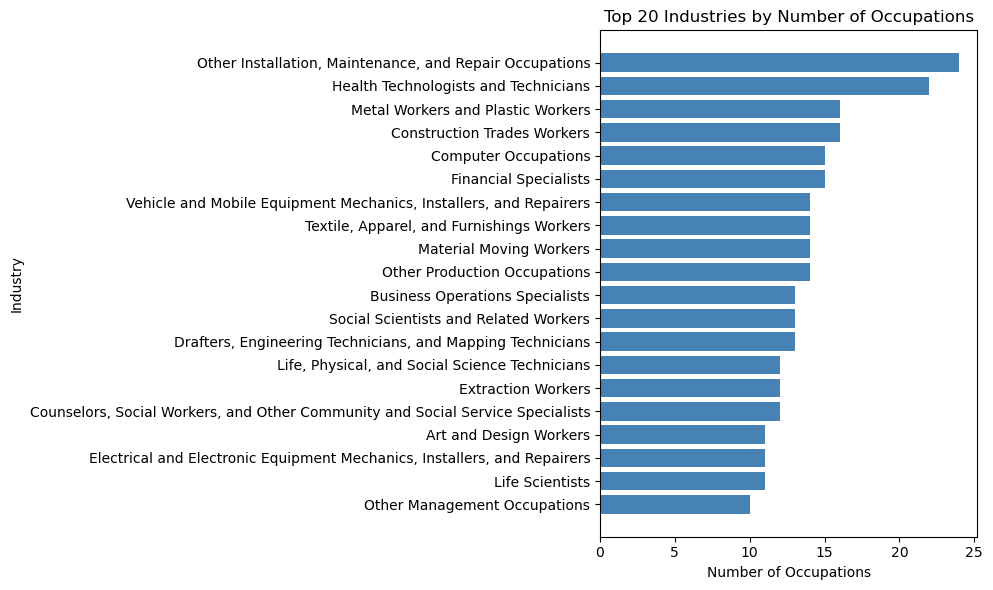

In [10]:
# 1. Number of occupations per industry
occ_per_ind = (
    onet.groupby("ind_name")["occ_title"]
    .nunique()
    .reset_index(name="num_occupations")
    .sort_values("num_occupations", ascending=False)
)

# Save results
occ_per_ind.to_csv(f'{output_data_path}/occupations_per_industry.csv', index=False)

# Plot (top 20 industries)
plt.figure(figsize=(10, 6))
plt.barh(
    occ_per_ind["ind_name"].head(20)[::-1],  # reverse for largest on top
    occ_per_ind["num_occupations"].head(20)[::-1],
    color="steelblue"
)
plt.title("Top 20 Industries by Number of Occupations")
plt.xlabel("Number of Occupations")
plt.ylabel("Industry")
plt.tight_layout()
plt.savefig(f'{output_plot_path}/occupations_per_industry.png')
plt.show()

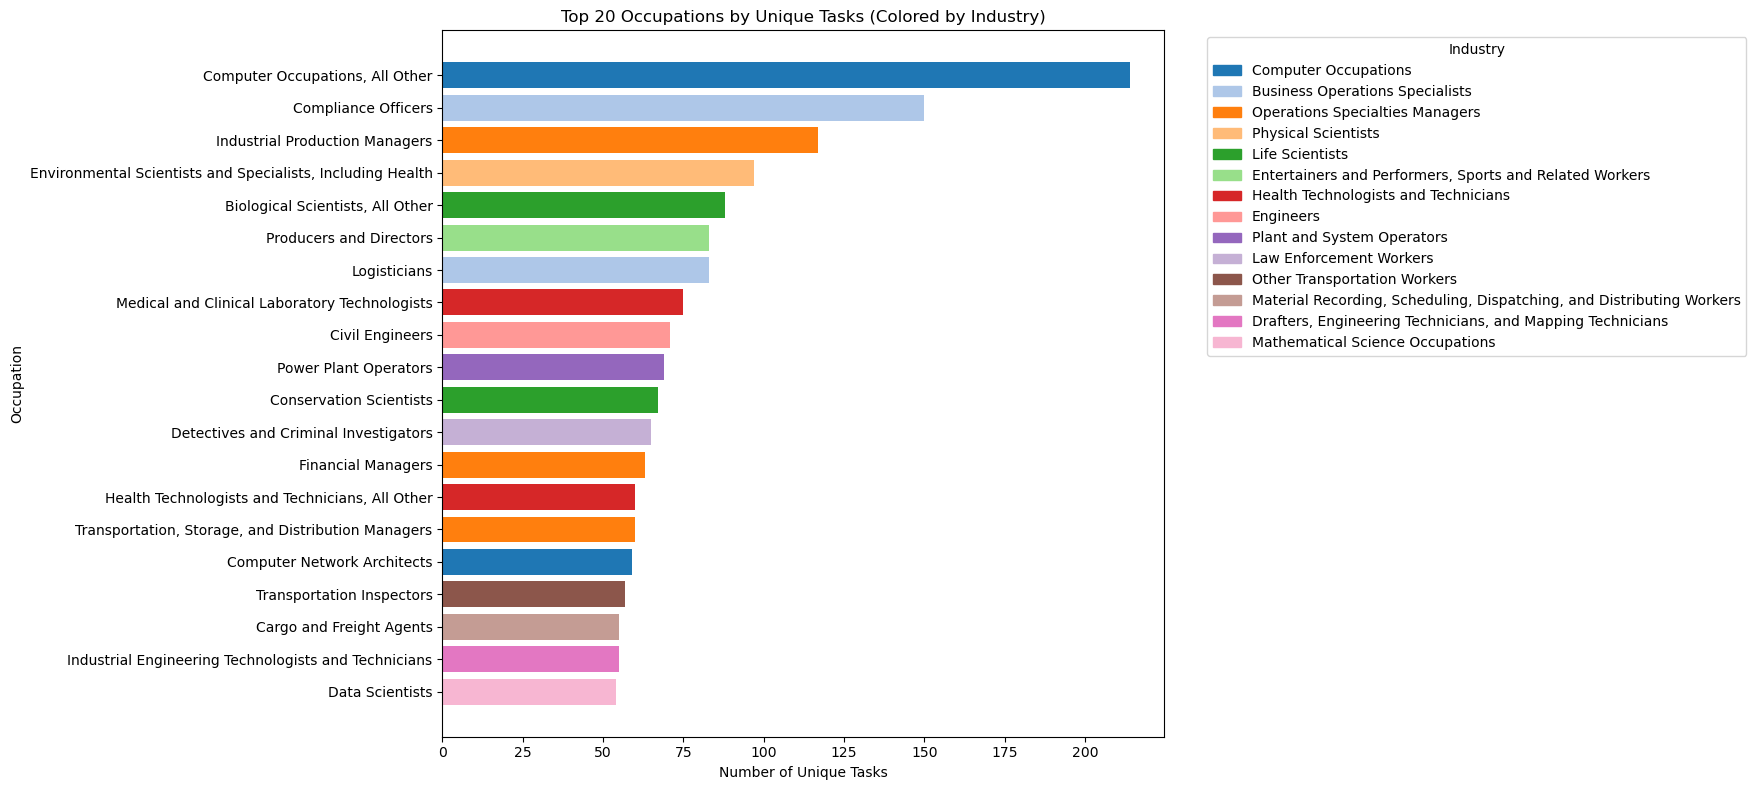

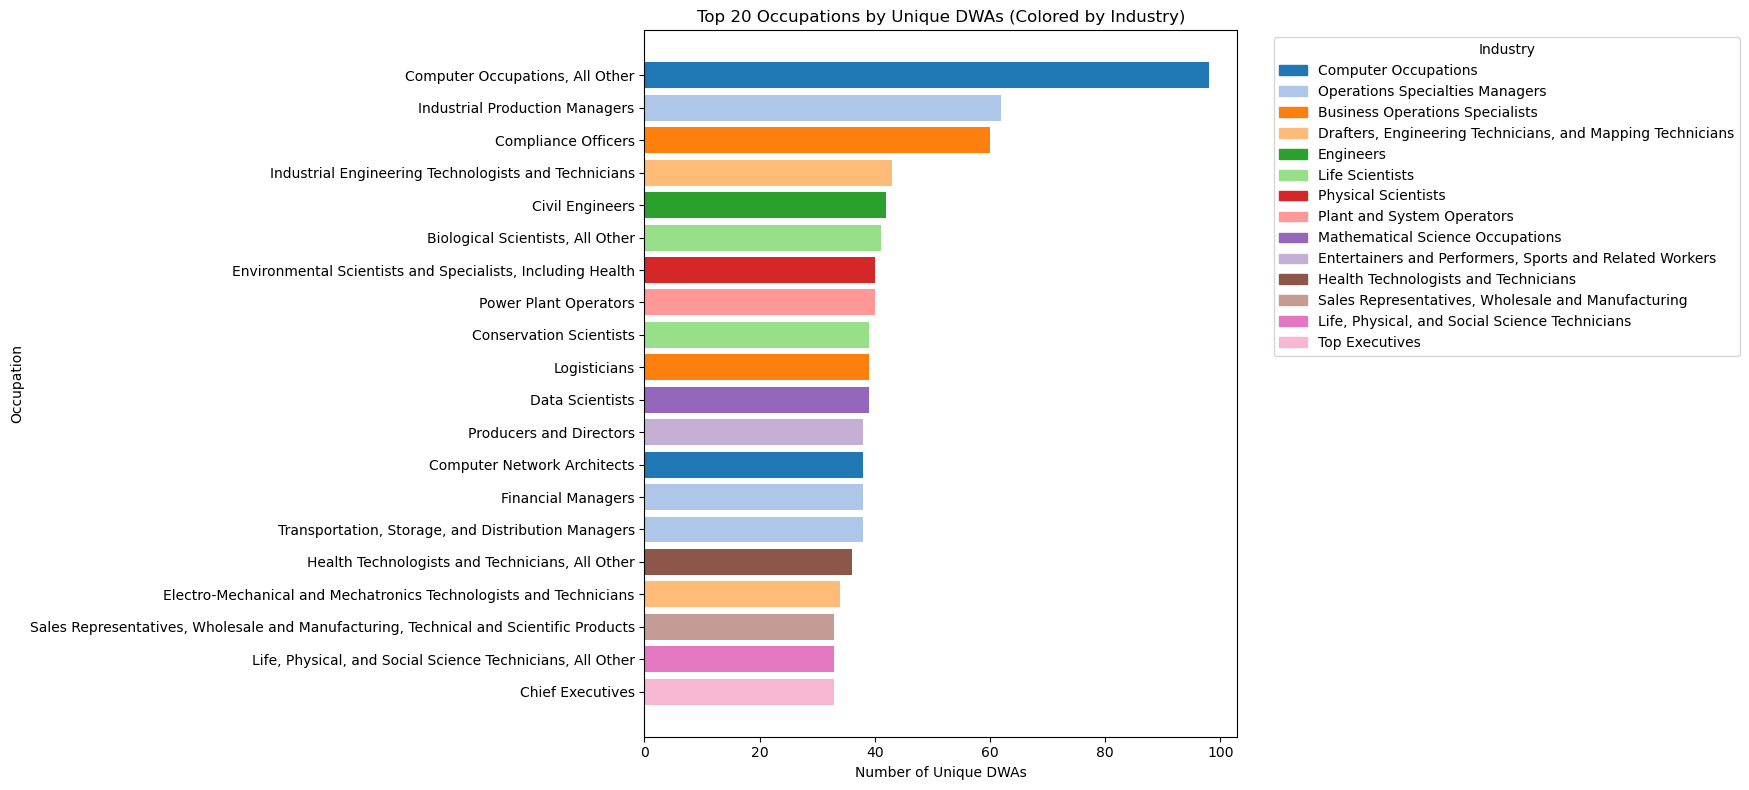

In [11]:
# 2. Number of unique tasks/DWAs/WAs per occupation
tasks_per_occ = (
    onet.groupby(['ind_name', "occ_title"])[["task", "dwa_title", "wa_name"]]
    .nunique()
    .reset_index()
    .rename(columns={
        "task": "num_unique_tasks",
        "dwa_title": "num_unique_DWAs",
        "wa_name": "num_unique_WAs"
    })
)

# Save results
tasks_per_occ.to_csv(f'{output_data_path}/unique_tasks_per_occupation.csv', index=False)


# ---- Plot 1: Top 20 occupations by tasks ----
top20_tasks = tasks_per_occ.sort_values("num_unique_tasks", ascending=False).head(20).copy()

plt.figure(figsize=(18, 8))

industries = top20_tasks["ind_name"].unique()
colors = plt.cm.tab20.colors
color_map = {ind: colors[i % len(colors)] for i, ind in enumerate(industries)}

y_labels = top20_tasks["occ_title"].iloc[::-1]
x_vals   = top20_tasks["num_unique_tasks"].iloc[::-1]
inds     = top20_tasks["ind_name"].iloc[::-1]

bars = plt.barh(y_labels, x_vals, color=[color_map[ind] for ind in inds])

plt.title("Top 20 Occupations by Unique Tasks (Colored by Industry)")
plt.xlabel("Number of Unique Tasks")
plt.ylabel("Occupation")

legend_patches = [plt.Rectangle((0,0),1,1, color=color_map[ind]) for ind in industries]
plt.legend(legend_patches, industries, title="Industry", 
           bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig(f"{output_plot_path}/unique_tasks_per_occupation_by_industry.png")
plt.show()


# ---- Plot 2: Top 20 occupations by DWAs ----
top20_dwas = tasks_per_occ.sort_values("num_unique_DWAs", ascending=False).head(20).copy()

plt.figure(figsize=(18, 8))

industries = top20_dwas["ind_name"].unique()
colors = plt.cm.tab20.colors
color_map = {ind: colors[i % len(colors)] for i, ind in enumerate(industries)}

y_labels = top20_dwas["occ_title"].iloc[::-1]
x_vals   = top20_dwas["num_unique_DWAs"].iloc[::-1]
inds     = top20_dwas["ind_name"].iloc[::-1]

bars = plt.barh(y_labels, x_vals, color=[color_map[ind] for ind in inds])

plt.title("Top 20 Occupations by Unique DWAs (Colored by Industry)")
plt.xlabel("Number of Unique DWAs")
plt.ylabel("Occupation")

legend_patches = [plt.Rectangle((0,0),1,1, color=color_map[ind]) for ind in industries]
plt.legend(legend_patches, industries, title="Industry", 
           bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig(f"{output_plot_path}/unique_dwas_per_occupation_by_industry.png")
plt.show()

In [12]:
# import numpy as np
# import matplotlib.pyplot as plt

# # --- Compute absolute counts per industry ---
# jobs_tasks_abs = (
#     onet.groupby("ind_name")
#     .agg(
#         num_unique_occ=("occ_title", "nunique"),
#         num_unique_tasks=("task", "nunique"),
#         num_unique_DWAs=("dwa_title", "nunique"),
#         num_unique_WAs=("wa_name", "nunique"),
#     )
#     .reset_index()
# )

# # Normalize values within each measure
# normed = jobs_tasks_abs.copy()
# normed["occ_norm"]   = normed["num_unique_occ"]   / normed["num_unique_occ"].max()
# normed["tasks_norm"] = normed["num_unique_tasks"] / normed["num_unique_tasks"].max()
# normed["DWAs_norm"]  = normed["num_unique_DWAs"]  / normed["num_unique_DWAs"].max()
# normed["WAs_norm"]   = normed["num_unique_WAs"]   / normed["num_unique_WAs"].max()

# # Sort industries by number of occupations (or whichever measure you prefer)
# normed = normed.sort_values("num_unique_occ", ascending=False)

# # --- Grouped bar plot (normalized, with raw counts as labels) ---
# ind = np.arange(len(normed))  # y positions
# bar_height = 0.2

# fig, ax = plt.subplots(figsize=(14, 0.6 * len(normed)))

# bars_occ  = ax.barh(ind - bar_height*1.5, normed["occ_norm"],   height=bar_height, color="steelblue", label="Occupations")
# bars_task = ax.barh(ind - bar_height*0.5, normed["tasks_norm"], height=bar_height, color="seagreen",  label="Tasks")
# bars_dwa  = ax.barh(ind + bar_height*0.5, normed["DWAs_norm"],  height=bar_height, color="darkorange",label="DWAs")
# bars_wa   = ax.barh(ind + bar_height*1.5, normed["WAs_norm"],   height=bar_height, color="purple",    label="WAs")

# # Labels and ticks
# ax.set_yticks(ind)
# ax.set_yticklabels(normed["ind_name"])
# ax.invert_yaxis()
# ax.set_title("Normalized Counts of Occupations, Tasks, DWAs, and WAs per Industry")
# ax.set_xlabel("Normalized Value (relative to max within each measure)")
# ax.legend()

# # Annotate bars with real (unnormalized) counts
# for bars, vals in [
#     (bars_occ,  normed["num_unique_occ"]),
#     (bars_task, normed["num_unique_tasks"]),
#     (bars_dwa,  normed["num_unique_DWAs"]),
#     (bars_wa,   normed["num_unique_WAs"]),
# ]:
#     for bar, val in zip(bars, vals):
#         ax.text(bar.get_width() + 0.005,  # offset so it doesn't overlap
#                 bar.get_y() + bar.get_height()/2.5,
#                 str(val), va="center", fontsize=8)

# plt.tight_layout()
# plt.savefig(f"{output_plot_path}/jobs_tasks_dwas_was_absolute_normalized.png")
# plt.show()

In [13]:
# import numpy as np
# import matplotlib.pyplot as plt

# # --- Compute measure as before ---
# jobs_tasks_ratio = (
#     onet.groupby("ind_name")
#     .agg(
#         num_unique_occ=("occ_title", "nunique"),
#         num_unique_tasks=("task", "nunique"),
#         num_unique_DWAs=("dwa_title", "nunique"),
#         num_unique_WAs=("wa_name", "nunique"),
#     )
#     .reset_index()
# )

# # Ratios (as percentages)
# jobs_tasks_ratio["jobs_per_task"] = (
#     jobs_tasks_ratio["num_unique_occ"] / jobs_tasks_ratio["num_unique_tasks"] * 100
# )
# jobs_tasks_ratio["jobs_per_DWA"] = (
#     jobs_tasks_ratio["num_unique_occ"] / jobs_tasks_ratio["num_unique_DWAs"] * 100
# )
# jobs_tasks_ratio["jobs_per_WA"] = (
#     jobs_tasks_ratio["num_unique_occ"] / jobs_tasks_ratio["num_unique_WAs"] * 100
# )

# # Sort industries by jobs_per_task (main metric)
# jobs_tasks_ratio = jobs_tasks_ratio.sort_values("jobs_per_task", ascending=False)

# # --- Normalize values for plotting ---
# normed = jobs_tasks_ratio.copy()
# normed["jobs_per_task_norm"] = normed["jobs_per_task"] / normed["jobs_per_task"].max()
# normed["jobs_per_DWA_norm"]  = normed["jobs_per_DWA"]  / normed["jobs_per_DWA"].max()
# normed["jobs_per_WA_norm"]   = normed["jobs_per_WA"]   / normed["jobs_per_WA"].max()

# # --- Grouped bar plot ---
# ind = np.arange(len(normed))  # y positions
# bar_height = 0.25

# fig, ax = plt.subplots(figsize=(14, 0.75 * len(normed)))

# # Bars
# bars_task = ax.barh(ind - bar_height, normed["jobs_per_task_norm"], height=bar_height, color="seagreen", label="Jobs per Task")
# bars_dwa  = ax.barh(ind, normed["jobs_per_DWA_norm"], height=bar_height, color="darkorange", label="Jobs per DWA")
# # bars_wa   = ax.barh(ind + bar_height, normed["jobs_per_WA_norm"], height=bar_height, color="purple", label="Jobs per WA")

# # Labels and ticks
# ax.set_yticks(ind)
# ax.set_yticklabels(normed["ind_name"])
# ax.invert_yaxis()  # highest values at top
# ax.set_title("Jobs per Task, DWA, and WA by Industry (normalized for comparison)\n\n**The higher the measure the higher the hand-off cost**\n")
# ax.set_xlabel("Normalized Value (relative to max within each measure)")
# ax.legend()

# # Annotate bars with real (unnormalized) values
# for bars, vals in [
#     (bars_task, normed["jobs_per_task"]),
#     (bars_dwa, normed["jobs_per_DWA"]),
#     # (bars_wa, normed["jobs_per_WA"]),
# ]:
#     for bar, val in zip(bars, vals):
#         ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/1.5,
#                 f"{val:.2f}%", va="center", fontsize=8)

# plt.tight_layout()
# plt.savefig(f"{output_plot_path}/jobs_per_task_dwa_wa_grouped_normalized.png")
# plt.show()

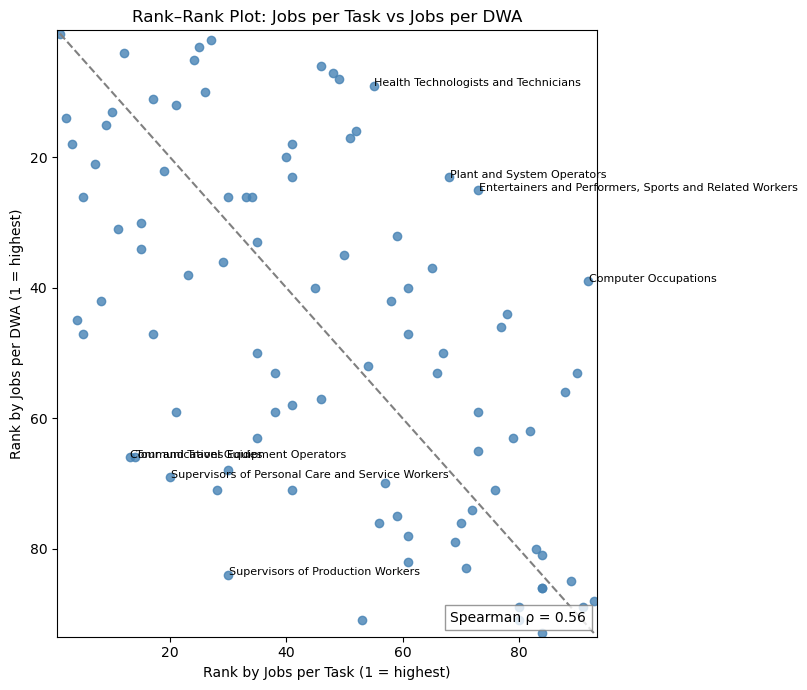

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Compute measures (reuse your pipeline if already available) ---
jobs_tasks_ratio = (
    onet.groupby("ind_name")
    .agg(
        num_unique_occ=("occ_title", "nunique"),
        num_unique_tasks=("task", "nunique"),
        num_unique_DWAs=("dwa_title", "nunique"),
        num_unique_WAs=("wa_name", "nunique"),
    )
    .reset_index()
)

# Ratios (%)
jobs_tasks_ratio["jobs_per_task"] = (
    jobs_tasks_ratio["num_unique_occ"] / jobs_tasks_ratio["num_unique_tasks"] * 100
)
jobs_tasks_ratio["jobs_per_DWA"] = (
    jobs_tasks_ratio["num_unique_occ"] / jobs_tasks_ratio["num_unique_DWAs"] * 100
)

# --- Rank each industry on both metrics (1 = best/highest) ---
# method='min' keeps integer ranks when ties happen (e.g., 1,1,3,...)
ranks = jobs_tasks_ratio.copy()
ranks["rank_task"] = ranks["jobs_per_task"].rank(method="min", ascending=False).astype(int)
ranks["rank_dwa"]  = ranks["jobs_per_DWA"].rank(method="min", ascending=False).astype(int)

# Rank difference (to spot mismatches)
ranks["rank_diff"] = (ranks["rank_task"] - ranks["rank_dwa"]).abs()

# --- Plot rank–rank scatter ---
fig, ax = plt.subplots(figsize=(8, 7))

ax.scatter(ranks["rank_task"], ranks["rank_dwa"], color="steelblue", alpha=0.8)

# Axes labels/titles
ax.set_xlabel("Rank by Jobs per Task (1 = highest)")
ax.set_ylabel("Rank by Jobs per DWA (1 = highest)")
ax.set_title("Rank–Rank Plot: Jobs per Task vs Jobs per DWA")

# 45° reference line (perfect agreement)
max_rank = int(max(ranks["rank_task"].max(), ranks["rank_dwa"].max()))
ax.plot([1, max_rank], [1, max_rank], linestyle="--", color="gray")

# Put best ranks (1) near origin and increase down/right
ax.set_xlim(0.5, max_rank + 0.5)
ax.set_ylim(0.5, max_rank + 0.5)
ax.invert_yaxis()  # optional: top-left is "best-best"
# (If you prefer bottom-left as best-best, remove invert_yaxis())

# --- Label biggest mismatches to highlight “top in one ≠ top in the other” ---
# Adjust N to taste
N = min(8, len(ranks))
outliers = ranks.sort_values("rank_diff", ascending=False).head(N)
for _, row in outliers.iterrows():
    ax.text(row["rank_task"] + 0.1, row["rank_dwa"] + 0.1, row["ind_name"],
            fontsize=8, color="black")

# Optional: Spearman rank correlation (agreement in ordering)
spearman = ranks[["rank_task", "rank_dwa"]].corr(method="spearman").iloc[0,1]
ax.text(0.98, 0.02, f"Spearman ρ = {spearman:.2f}",
        transform=ax.transAxes, ha="right", va="bottom",
        fontsize=10, bbox=dict(facecolor="white", edgecolor="gray", alpha=0.8))

plt.tight_layout()
plt.savefig(f"{output_plot_path}/rank_rank_jobs_per_task_vs_dwa.png")
plt.show()

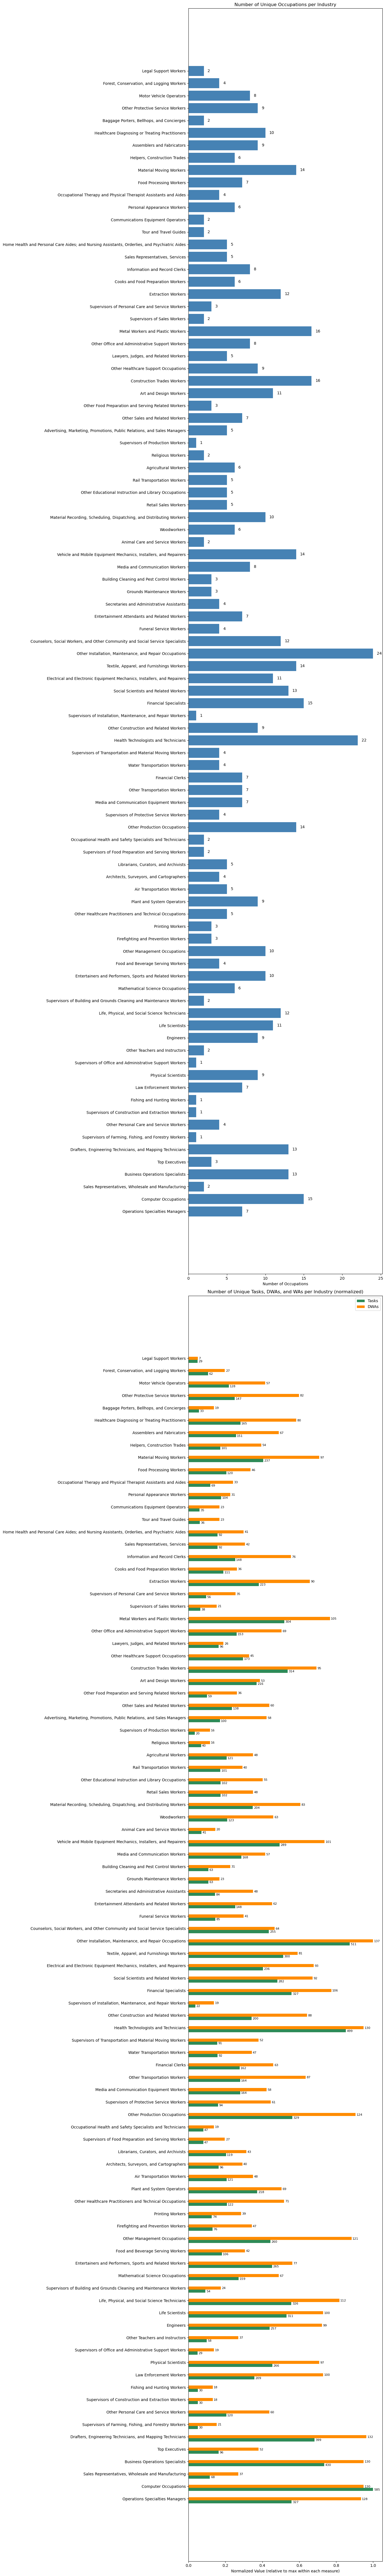

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# --- Compute measure as before ---
jobs_tasks_ratio = (
    onet.groupby("ind_name")
    .agg(
        num_unique_occ=("occ_title", "nunique"),
        num_unique_tasks=("task", "nunique"),
        num_unique_DWAs=("dwa_title", "nunique"),
        num_unique_WAs=("wa_name", "nunique"),
    )
    .reset_index()
)

jobs_tasks_ratio["jobs_per_task"] = (
    jobs_tasks_ratio["num_unique_occ"] / jobs_tasks_ratio["num_unique_tasks"]
)

# Sort industries by jobs_per_task
jobs_tasks_ratio = jobs_tasks_ratio.sort_values("jobs_per_task", ascending=True)

# --- Normalize for grouped plot ---
normed = jobs_tasks_ratio.copy()
normed["tasks_norm"] = normed["num_unique_tasks"] / normed["num_unique_tasks"].max()
normed["DWAs_norm"]  = normed["num_unique_DWAs"] / normed["num_unique_DWAs"].max()
normed["WAs_norm"]   = normed["num_unique_WAs"] / normed["num_unique_WAs"].max()

# --- Plot: Occupations (first) + grouped Tasks/DWAs/WAs (normalized) ---
fig, axes = plt.subplots(2, 1, figsize=(14, 0.5 * len(jobs_tasks_ratio) * 2), sharey=True)

# 1. Occupations (raw counts, unchanged)
bars_occ = axes[0].barh(
    jobs_tasks_ratio["ind_name"],
    jobs_tasks_ratio["num_unique_occ"],
    color="steelblue"
)
axes[0].set_title("Number of Unique Occupations per Industry")
axes[0].set_xlabel("Number of Occupations")
for bar, val in zip(bars_occ, jobs_tasks_ratio["num_unique_occ"]):
    axes[0].text(val + 0.5, bar.get_y() + bar.get_height()/2, str(val), va="center")

# 2. Grouped (normalized) Tasks / DWAs / WAs
ind = np.arange(len(normed))
bar_height = 0.25

bars_task = axes[1].barh(ind - bar_height, normed["tasks_norm"], height=bar_height, color="seagreen", label="Tasks")
bars_dwa  = axes[1].barh(ind,             normed["DWAs_norm"],  height=bar_height, color="darkorange", label="DWAs")
# bars_wa   = axes[1].barh(ind + bar_height, normed["WAs_norm"],   height=bar_height, color="purple", label="WAs")

axes[1].set_yticks(ind)
axes[1].set_yticklabels(normed["ind_name"])
axes[1].set_title("Number of Unique Tasks, DWAs, and WAs per Industry (normalized)")
axes[1].set_xlabel("Normalized Value (relative to max within each measure)")
axes[1].legend()

# Annotate with actual numbers (not normalized)
for bars, vals in [
    (bars_task, normed["num_unique_tasks"]),
    (bars_dwa, normed["num_unique_DWAs"]),
    # (bars_wa, normed["num_unique_WAs"]),
]:
    for bar, val in zip(bars, vals):
        axes[1].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2.5,
                     str(val), va="center", fontsize=8)

plt.tight_layout()
plt.savefig(f"{output_plot_path}/jobs_tasks_dwas_was_grouped_normalized_by_industry.png")
plt.show()

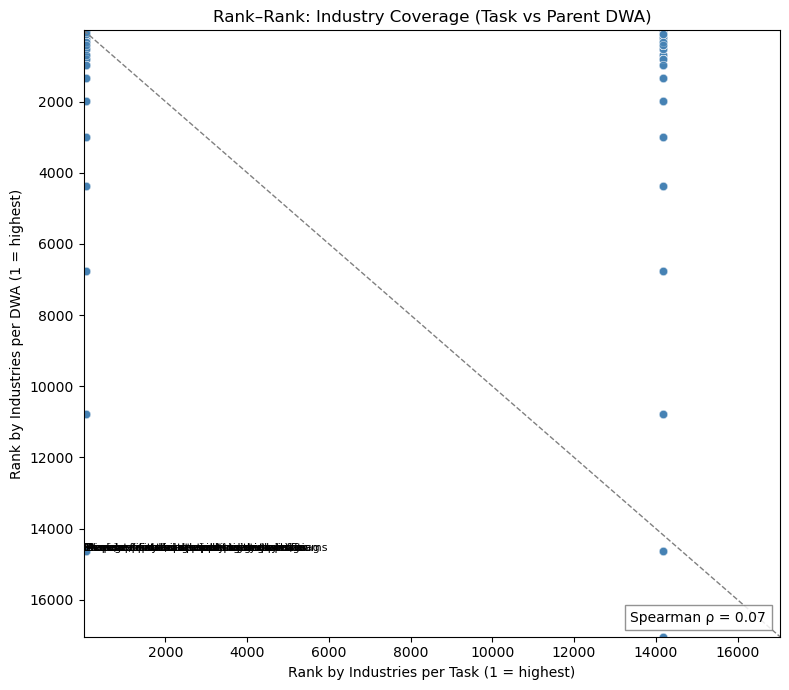

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Compute measures (reuse your pipeline if already available) ---
jobs_tasks_ratio = (
    onet.groupby("ind_name")
    .agg(
        num_unique_occ=("occ_title", "nunique"),
        num_unique_tasks=("task", "nunique"),
        num_unique_DWAs=("dwa_title", "nunique"),
        num_unique_WAs=("wa_name", "nunique"),
    )
    .reset_index()
)

# Ratios (%)
jobs_tasks_ratio["jobs_per_task"] = (
    jobs_tasks_ratio["num_unique_occ"] / jobs_tasks_ratio["num_unique_tasks"] * 100
)
jobs_tasks_ratio["jobs_per_DWA"] = (
    jobs_tasks_ratio["num_unique_occ"] / jobs_tasks_ratio["num_unique_DWAs"] * 100
)

# --- Rank each industry on both metrics (1 = best/highest) ---
# method='min' keeps integer ranks when ties happen (e.g., 1,1,3,...)
ranks = jobs_tasks_ratio.copy()
ranks["rank_task"] = ranks["jobs_per_task"].rank(method="min", ascending=False).astype(int)
ranks["rank_dwa"]  = ranks["jobs_per_DWA"].rank(method="min", ascending=False).astype(int)

# Rank difference (to spot mismatches)
ranks["rank_diff"] = (ranks["rank_task"] - ranks["rank_dwa"]).abs()

# --- Plot rank–rank scatter ---
fig, ax = plt.subplots(figsize=(8, 7))

ax.scatter(ranks["rank_task"], ranks["rank_dwa"], color="steelblue", alpha=0.8)

# Axes labels/titles
ax.set_xlabel("Rank by Jobs per Task (1 = highest)")
ax.set_ylabel("Rank by Jobs per DWA (1 = highest)")
ax.set_title("Rank–Rank Plot: Jobs per Task vs Jobs per DWA")

# 45° reference line (perfect agreement)
max_rank = int(max(ranks["rank_task"].max(), ranks["rank_dwa"].max()))
ax.plot([1, max_rank], [1, max_rank], linestyle="--", color="gray")

# Put best ranks (1) near origin and increase down/right
ax.set_xlim(0.5, max_rank + 0.5)
ax.set_ylim(0.5, max_rank + 0.5)
ax.invert_yaxis()  # optional: top-left is "best-best"
# (If you prefer bottom-left as best-best, remove invert_yaxis())

# --- Label biggest mismatches to highlight “top in one ≠ top in the other” ---
# Adjust N to taste
N = min(8, len(ranks))
outliers = ranks.sort_values("rank_diff", ascending=False).head(N)
for _, row in outliers.iterrows():
    ax.text(row["rank_task"] + 0.1, row["rank_dwa"] + 0.1, row["ind_name"],
            fontsize=8, color="black")

# Optional: Spearman rank correlation (agreement in ordering)
spearman = ranks[["rank_task", "rank_dwa"]].corr(method="spearman").iloc[0,1]
ax.text(0.98, 0.02, f"Spearman ρ = {spearman:.2f}",
        transform=ax.transAxes, ha="right", va="bottom",
        fontsize=10, bbox=dict(facecolor="white", edgecolor="gray", alpha=0.8))

plt.tight_layout()
plt.savefig(f"{output_plot_path}/rank_rank_jobs_per_task_vs_dwa.png")
plt.show()

Slope for Jobs vs Tasks: 0.037
Slope for Jobs vs DWAs: 0.123


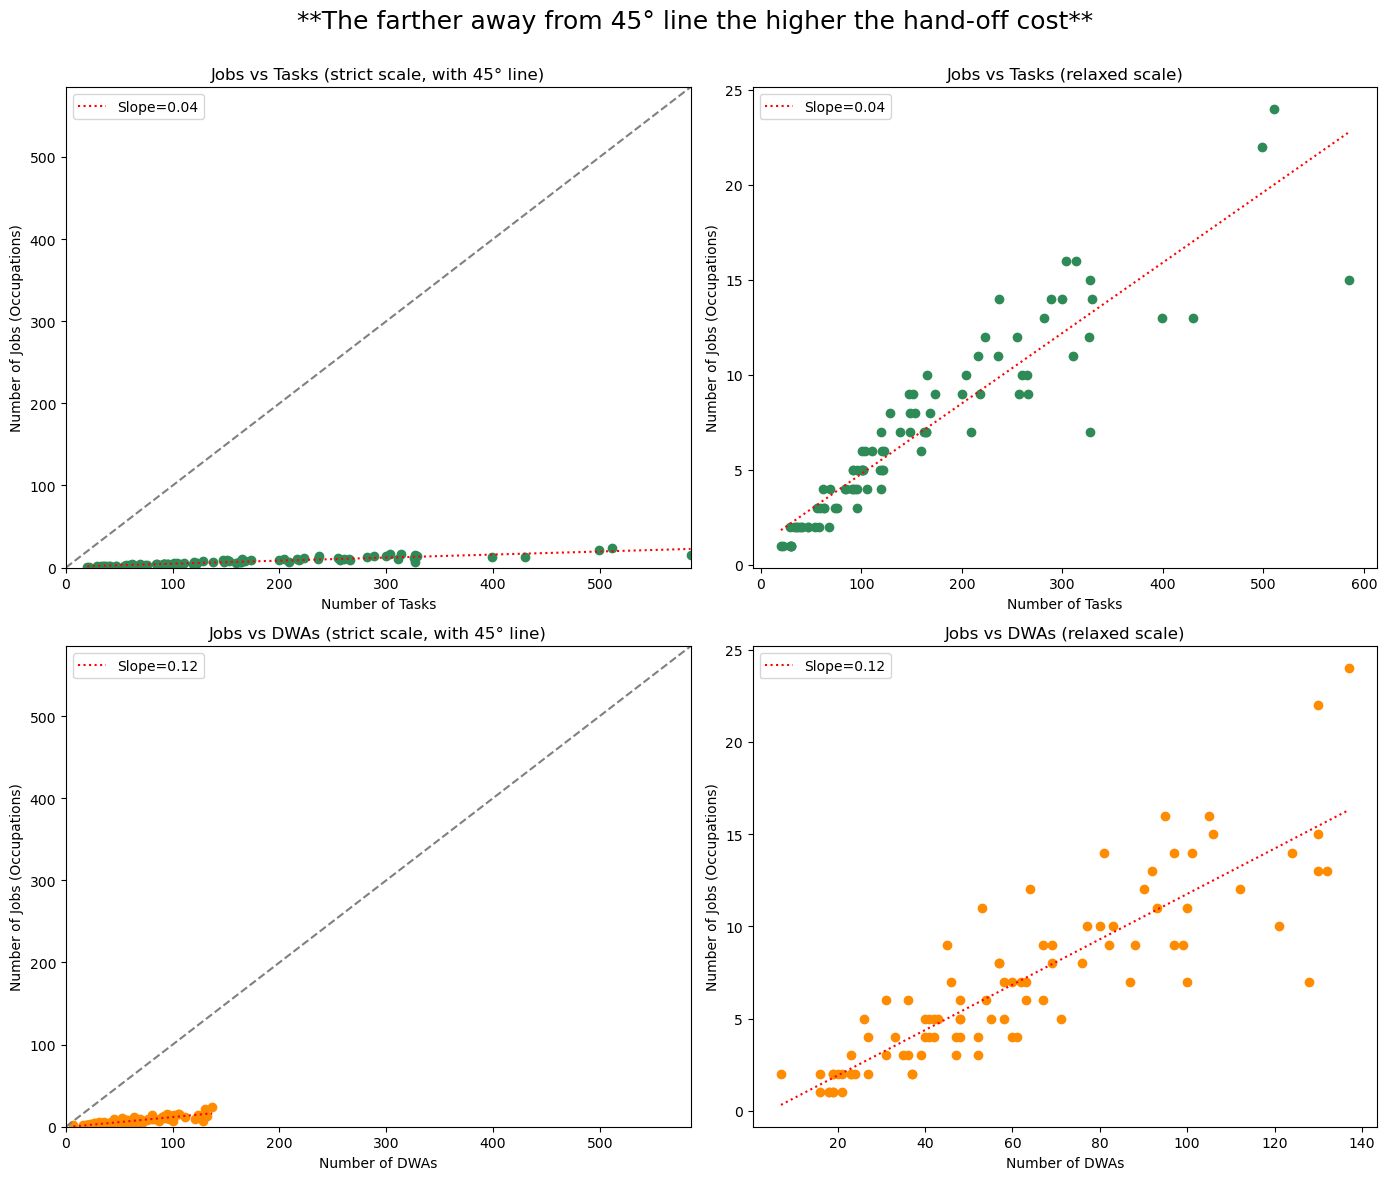

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# --- Compute absolute counts per industry ---
jobs_tasks_abs = (
    onet.groupby("ind_name")
    .agg(
        num_unique_occ=("occ_title", "nunique"),
        num_unique_tasks=("task", "nunique"),
        num_unique_DWAs=("dwa_title", "nunique"),
        # num_unique_WAs=("wa_name", "nunique"),
    )
    .reset_index()
)

# Determine common axis limits for column 1 (strict)
max_x = jobs_tasks_abs["num_unique_occ"].max()
max_y = max(
    jobs_tasks_abs["num_unique_tasks"].max(),
    jobs_tasks_abs["num_unique_DWAs"].max(),
    # jobs_tasks_abs["num_unique_WAs"].max()
)
limit = max(max_x, max_y)

# --- Scatter plots in 3x2 grid ---
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=False, sharey=False)

# Data config
measures = [
    ("num_unique_tasks", "Tasks", "seagreen"),
    ("num_unique_DWAs", "DWAs", "darkorange"),
    # ("num_unique_WAs", "WAs", "purple"),
]

for i, (col, label, color) in enumerate(measures):
    x = jobs_tasks_abs[col].values
    y = jobs_tasks_abs["num_unique_occ"].values

    # Fit line (simple linear regression y = m*x + b)
    slope, intercept = np.polyfit(x, y, 1)

    # Print slope to console
    print(f"Slope for Jobs vs {label}: {slope:.3f}")

    # Generate fit line
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = slope * x_fit + intercept

    # Left column: strict axis with 45° line
    axes[i, 0].scatter(x, y, color=color)
    axes[i, 0].plot([0, limit], [0, limit], linestyle="--", color="gray")
    axes[i, 0].plot(x_fit, y_fit, linestyle=":", color="red", label=f"Slope={slope:.2f}")
    axes[i, 0].set_title(f"Jobs vs {label} (strict scale, with 45° line)")
    axes[i, 0].set_xlabel(f"Number of {label}")
    axes[i, 0].set_ylabel("Number of Jobs (Occupations)")
    axes[i, 0].set_xlim(0, limit)
    axes[i, 0].set_ylim(0, limit)
    axes[i, 0].legend()

    # Right column: relaxed axis (autoscale)
    axes[i, 1].scatter(x, y, color=color)
    axes[i, 1].plot(x_fit, y_fit, linestyle=":", color="red", label=f"Slope={slope:.2f}")
    axes[i, 1].set_title(f"Jobs vs {label} (relaxed scale)")
    axes[i, 1].set_xlabel(f"Number of {label}")
    axes[i, 1].set_ylabel("Number of Jobs (Occupations)")
    axes[i, 1].legend()

# Add super title on top of all subplots
fig.suptitle("**The farther away from 45° line the higher the hand-off cost**\n", fontsize=18)

plt.tight_layout()
plt.savefig(f"{output_plot_path}/jobs_vs_tasks_dwas_was_scatter_with_fit.png")
plt.show()

In [38]:
# Load and rename columns
gpts_df = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/occ_level.csv')
gpts_df = gpts_df.rename(columns={
    'O*NET-SOC Code': 'occ_code',
    'Title': 'occ_title',
    'dv_rating_gamma': 'gpt4_score',
    'human_rating_gamma': 'human_score'
})
gpts_df = gpts_df[['occ_code', 'occ_title', 'gpt4_score', 'human_score']]


# Keep only codes ending in '00' and remove the '.00' suffix
gpts_df = gpts_df[gpts_df['occ_code'].astype(str).str.endswith('00')].copy()
gpts_df['occ_code'] = gpts_df['occ_code'].astype(str).str.replace(r'\.00$', '', regex=True)
gpts_df

,occ_code,occ_title,gpt4_score,human_score
0,11-1011,Chief Executives,0.82,0.52
2,11-1021,General and Operations Managers,0.96,0.65
3,11-1031,Legislators,0.77,0.77
4,11-2011,Advertising and Promotions Managers,0.95,0.84
5,11-2021,Marketing Managers,0.94,0.94
...,...,...,...,...
918,53-7071,Gas Compressor and Gas Pumping Station Operators,0.31,0.15
919,53-7072,"Pump Operators, Except Wellhead Pumpers",0.33,0.33
920,53-7073,Wellhead Pumpers,0.00,0.00
921,53-7081,Refuse and Recyclable Material Collectors,0.21,0.36


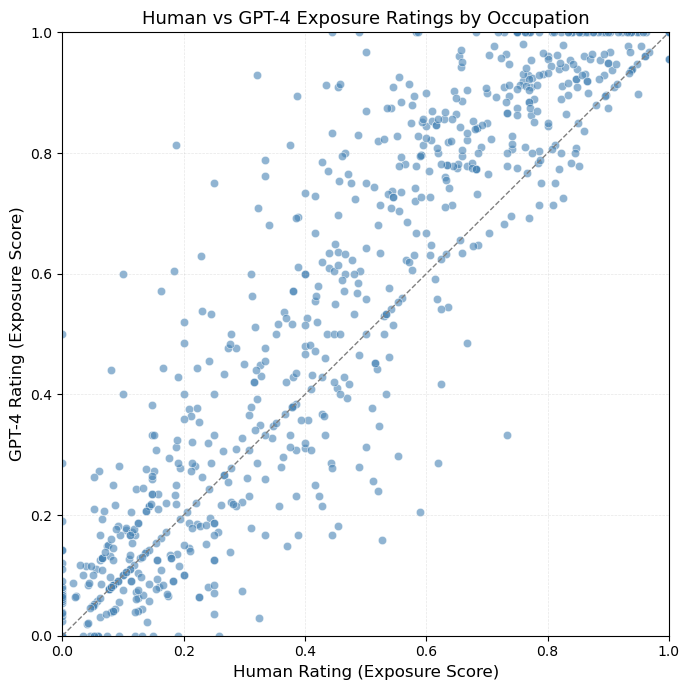

In [39]:
# Scatterplot
plt.figure(figsize=(7, 7))
plt.scatter(gpts_df['human_score'], gpts_df['gpt4_score'],
            alpha=0.6, color='steelblue', edgecolors='white', linewidth=0.5)

# Axis labels and line of equality
plt.xlabel('Human Rating (Exposure Score)', fontsize=12)
plt.ylabel('GPT-4 Rating (Exposure Score)', fontsize=12)
plt.title('Human vs GPT-4 Exposure Ratings by Occupation', fontsize=13)
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1)  # 45° line for reference

# Tidy axes and layout
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(alpha=0.3, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [40]:
# Merge the two datasets on occ_code and occ_title
merged_df = onet.merge(gpts_df, on=['occ_code', 'occ_title'], how='left')
merged_df

,year,occ_code,occ_title,task_id,task,task_type,wa_id,wa_name,dwa_id,dwa_title,...,daily,several_times_daily,hourly_or_more,task_importance,task_relevance,wa_importance,ind,ind_name,gpt4_score,human_score
0,2023,11-1011,Chief Executives,8833,"Preside over, or serve on, boards of directors...",Core,NaN,NaN,NaN,NaN,...,4.28,3.02,0.00,3.96,72.72,NaN,11-10,Top Executives,0.82,0.52
1,2023,11-1011,Chief Executives,8835,Establish departmental responsibilities and co...,Core,NaN,NaN,NaN,NaN,...,14.05,5.55,0.00,3.96,84.86,NaN,11-10,Top Executives,0.82,0.52
2,2023,11-1011,Chief Executives,8842,Nominate citizens to boards or commissions.,Supplemental,NaN,NaN,NaN,NaN,...,4.48,0.00,0.00,2.81,26.95,NaN,11-10,Top Executives,0.82,0.52
3,2023,11-1011,Chief Executives,8845,Refer major policy matters to elected represen...,Supplemental,NaN,NaN,NaN,NaN,...,0.00,2.60,0.00,3.92,46.48,NaN,11-10,Top Executives,0.82,0.52
4,2023,11-1011,Chief Executives,8848,Direct or conduct studies or research on issue...,Core,NaN,NaN,NaN,NaN,...,4.58,0.20,0.79,3.33,75.11,NaN,11-10,Top Executives,0.82,0.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17940,2023,49-9062,Medical Equipment Repairers,23980,"Inspect, test, or troubleshoot malfunctioning ...",Core,4.A.1.b.2,"Inspecting Equipment, Structures, or Materials",4.A.1.b.2.I07.D20,"Inspect mechanical equipment to locate damage,...",...,47.52,14.27,12.62,4.55,99.61,4.20,49-90,"Other Installation, Maintenance, and Repair Oc...",0.45,0.33
17941,2023,49-9062,Medical Equipment Repairers,23981,Install medical equipment.,Core,4.A.3.a.2,Handling and Moving Objects,4.A.3.a.2.I46.D01,Install equipment attachments or components.,...,4.49,0.00,2.96,4.14,84.12,3.59,49-90,"Other Installation, Maintenance, and Repair Oc...",0.45,0.33
17942,2023,51-6061,Textile Bleaching and Dyeing Machine Operators...,23982,"Weigh ingredients, such as dye, to be mixed to...",Core,4.A.1.b.3,Estimating the Quantifiable Characteristics of...,4.A.1.b.3.I01.D10,Measure ingredients or substances to be used i...,...,35.29,20.00,29.01,4.64,68.72,2.88,51-60,"Textile, Apparel, and Furnishings Workers",0.18,0.24
17943,2023,51-9023,"Mixing and Blending Machine Setters, Operators...",23983,Clean work areas.,Core,4.A.3.a.1,Performing General Physical Activities,4.A.3.a.1.I03.D05,Clean work areas.,...,76.15,6.12,17.16,4.26,100.00,4.22,51-90,Other Production Occupations,0.11,0.11


In [41]:
# Let me understand the data structure for the industry-level analysis
print("ONET DataFrame columns:")
print(onet.columns.tolist())
print(f"\nShape: {onet.shape}")
print(f"\nSample of data structure:")
print(onet[['ind_name', 'occ_title', 'task', 'dwa_title']].head(10))

ONET DataFrame columns:
['year', 'occ_code', 'occ_title', 'task_id', 'task', 'task_type', 'wa_id', 'wa_name', 'dwa_id', 'dwa_title', 'yearly_or_less', 'more_than_yearly', 'more_than_monthly', 'more_than_weekly', 'daily', 'several_times_daily', 'hourly_or_more', 'task_importance', 'task_relevance', 'wa_importance', 'ind', 'ind_name']

Shape: (17945, 22)

Sample of data structure:
         ind_name         occ_title  \
0  Top Executives  Chief Executives   
1  Top Executives  Chief Executives   
2  Top Executives  Chief Executives   
3  Top Executives  Chief Executives   
4  Top Executives  Chief Executives   
5  Top Executives  Chief Executives   
6  Top Executives  Chief Executives   
7  Top Executives  Chief Executives   
8  Top Executives  Chief Executives   
9  Top Executives  Chief Executives   

                                                task  \
0  Preside over, or serve on, boards of directors...   
1  Establish departmental responsibilities and co...   
2        Nominate ci

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Compute measures: Industries per Task and Industries per DWA ---

# Group by task to get industries per task
ind_per_task = (
    onet.groupby("task")
    .agg(
        num_unique_industries=("ind_name", "nunique"),
        num_unique_occ=("occ_title", "nunique"),
        num_unique_dwas=("dwa_title", "nunique")
    )
    .reset_index()
)

# Group by DWA to get industries per DWA (excluding NaN DWAs)
ind_per_dwa = (
    onet[onet['dwa_title'].notna()]  # Remove rows where dwa_title is NaN
    .groupby("dwa_title")
    .agg(
        num_unique_industries=("ind_name", "nunique"),
        num_unique_occ=("occ_title", "nunique"),
        num_unique_tasks=("task", "nunique")
    )
    .reset_index()
)

print(f"Number of unique tasks: {len(ind_per_task)}")
print(f"Number of unique DWAs: {len(ind_per_dwa)}")
print(f"Max industries per task: {ind_per_task['num_unique_industries'].max()}")
print(f"Max industries per DWA: {ind_per_dwa['num_unique_industries'].max()}")

# Preview the data
print("\nTop 5 tasks by number of industries:")
print(ind_per_task.nlargest(5, 'num_unique_industries')[['task', 'num_unique_industries']])

print("\nTop 5 DWAs by number of industries:")
print(ind_per_dwa.nlargest(5, 'num_unique_industries')[['dwa_title', 'num_unique_industries']])

Number of unique tasks: 17631
Number of unique DWAs: 2067
Max industries per task: 3
Max industries per DWA: 24

Top 5 tasks by number of industries:
                                                    task  \
12983  Provide disabled students with assistive devic...   
14519  Resolve customer complaints regarding worker p...   
472    Analyze and record personnel or operational da...   
772    Apply customer feedback to service improvement...   
1200   Assign the patient to diagnosis-related groups...   

       num_unique_industries  
12983                      3  
14519                      3  
472                        2  
772                        2  
1200                       2  

Top 5 DWAs by number of industries:
                                              dwa_title  num_unique_industries
1443           Order materials, supplies, or equipment.                     24
899       Explain regulations, policies, or procedures.                     22
1694             Record opera

In [43]:
# For rank-rank analysis, I need to create comparable entities. 
# Let me think about this differently. Since tasks and DWAs are different dimensions,
# I'll create a rank-rank analysis that compares how entities (could be occupations, industries, etc.)
# rank on "industries per task" vs "industries per DWA"

# Let me explore the task-DWA relationship first
task_to_dwa = onet[onet['dwa_title'].notna()].groupby(['task', 'dwa_title']).size().reset_index(name='count')
print(f"Number of unique task-DWA pairs: {len(task_to_dwa)}")

# Let's see the relationship
sample_task_dwa = onet[onet['dwa_title'].notna()][['task', 'dwa_title', 'ind_name', 'occ_title']].head(10)
print("Sample task-DWA-industry relationships:")
print(sample_task_dwa)

Number of unique task-DWA pairs: 17226
Sample task-DWA-industry relationships:
                                                 task  \
6   Analyze operations to evaluate performance of ...   
7   Review reports submitted by staff members to r...   
8   Review and analyze legislation, laws, or publi...   
9   Direct, plan, or implement policies, objective...   
10  Prepare bylaws approved by elected officials, ...   
11  Prepare or present reports concerning activiti...   
12  Interpret and explain policies, rules, regulat...   
13  Serve as liaisons between organizations, share...   
14  Confer with board members, organization offici...   
15  Make presentations to legislative or other gov...   

                                            dwa_title        ind_name  \
6   Analyze data to assess operational or project ...  Top Executives   
7   Analyze data to inform operational decisions o...  Top Executives   
8      Analyze impact of legal or regulatory changes.  Top Executives   
9

In [24]:
# Create rank-rank analysis for occupations based on industry diversity
# Approach: For each occupation, calculate the average industry diversity of its tasks and DWAs

# Step 1: Calculate industry diversity for each task and DWA
task_industry_diversity = ind_per_task[['task', 'num_unique_industries']].rename(
    columns={'num_unique_industries': 'task_ind_diversity'}
)

dwa_industry_diversity = ind_per_dwa[['dwa_title', 'num_unique_industries']].rename(
    columns={'num_unique_industries': 'dwa_ind_diversity'}
)

# Step 2: For each occupation, calculate average industry diversity of its tasks and DWAs
occ_task_diversity = (
    onet.merge(task_industry_diversity, on='task', how='left')
    .groupby(['occ_title', 'ind_name'])
    .agg(avg_task_ind_diversity=('task_ind_diversity', 'mean'))
    .reset_index()
)

occ_dwa_diversity = (
    onet[onet['dwa_title'].notna()]
    .merge(dwa_industry_diversity, on='dwa_title', how='left')
    .groupby(['occ_title', 'ind_name'])
    .agg(avg_dwa_ind_diversity=('dwa_ind_diversity', 'mean'))
    .reset_index()
)

# Step 3: Merge and create the final dataset
occ_industry_analysis = occ_task_diversity.merge(
    occ_dwa_diversity, 
    on=['occ_title', 'ind_name'], 
    how='inner'  # Only keep occupations that have both tasks and DWAs
)

print(f"Number of occupation-industry pairs with both task and DWA data: {len(occ_industry_analysis)}")
print("\nSample data:")
print(occ_industry_analysis.head())

Number of occupation-industry pairs with both task and DWA data: 640

Sample data:
                                           occ_title  \
0                           Accountants and Auditors   
1                                             Actors   
2                                          Actuaries   
3  Administrative Law Judges, Adjudicators, and H...   
4                   Administrative Services Managers   

                                            ind_name  avg_task_ind_diversity  \
0                              Financial Specialists                    1.00   
1  Entertainers and Performers, Sports and Relate...                    1.00   
2                   Mathematical Science Occupations                    1.00   
3               Lawyers, Judges, and Related Workers                    1.00   
4                    Operations Specialties Managers                    1.06   

   avg_dwa_ind_diversity  
0                   3.37  
1                   2.53  
2                 

In [25]:
# Aggregate at occupation level (average across industries)
occ_final = (
    occ_industry_analysis.groupby('occ_title')
    .agg(
        avg_task_ind_diversity=('avg_task_ind_diversity', 'mean'),
        avg_dwa_ind_diversity=('avg_dwa_ind_diversity', 'mean'),
        num_industries=('ind_name', 'nunique')
    )
    .reset_index()
)

# Create the metrics similar to your original "industries per task" and "industries per DWA"
occ_final["industries_per_task"] = occ_final["avg_task_ind_diversity"]
occ_final["industries_per_dwa"] = occ_final["avg_dwa_ind_diversity"]

# --- Rank each occupation on both metrics (1 = best/highest) ---
ranks = occ_final.copy()
ranks["rank_task"] = ranks["industries_per_task"].rank(method="min", ascending=False).astype(int)
ranks["rank_dwa"] = ranks["industries_per_dwa"].rank(method="min", ascending=False).astype(int)

# Rank difference (to spot mismatches)
ranks["rank_diff"] = (ranks["rank_task"] - ranks["rank_dwa"]).abs()

print(f"Number of occupations for rank-rank analysis: {len(ranks)}")
print("\nTop 5 occupations by industries per task:")
print(ranks.nlargest(5, 'industries_per_task')[['occ_title', 'industries_per_task', 'industries_per_dwa']])

print("\nTop 5 occupations by industries per DWA:")
print(ranks.nlargest(5, 'industries_per_dwa')[['occ_title', 'industries_per_task', 'industries_per_dwa']])

print("\nOccupations with biggest rank differences:")
print(ranks.nlargest(5, 'rank_diff')[['occ_title', 'rank_task', 'rank_dwa', 'rank_diff']])

Number of occupations for rank-rank analysis: 640

Top 5 occupations by industries per task:
                                             occ_title  industries_per_task  \
258  First-Line Supervisors of Personal Service Wor...                 1.71   
257     First-Line Supervisors of Passenger Attendants                 1.68   
245  First-Line Supervisors of Entertainment and Re...                 1.63   
308  Health Information Technologists and Medical R...                 1.31   
403                        Medical Records Specialists                 1.29   

     industries_per_dwa  
258                9.47  
257                9.95  
245                9.05  
308                3.25  
403                3.53  

Top 5 occupations by industries per DWA:
                                             occ_title  industries_per_task  \
257     First-Line Supervisors of Passenger Attendants                 1.68   
23                 Amusement and Recreation Attendants                 1.00 

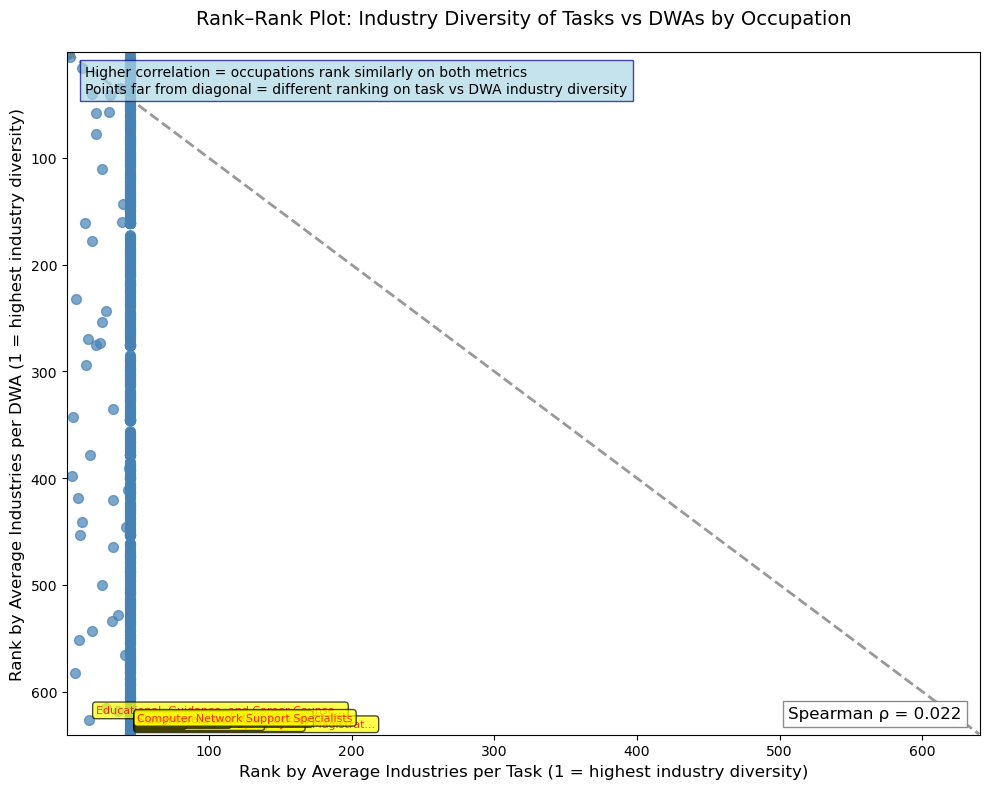

In [26]:
# --- Plot rank–rank scatter for Industries per Task vs Industries per DWA ---
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(ranks["rank_task"], ranks["rank_dwa"], color="steelblue", alpha=0.7, s=50)

# Axes labels/titles
ax.set_xlabel("Rank by Average Industries per Task (1 = highest industry diversity)", fontsize=12)
ax.set_ylabel("Rank by Average Industries per DWA (1 = highest industry diversity)", fontsize=12)
ax.set_title("Rank–Rank Plot: Industry Diversity of Tasks vs DWAs by Occupation", fontsize=14, pad=20)

# 45° reference line (perfect agreement)
max_rank = int(max(ranks["rank_task"].max(), ranks["rank_dwa"].max()))
ax.plot([1, max_rank], [1, max_rank], linestyle="--", color="gray", alpha=0.8, linewidth=2)

# Set axis limits
ax.set_xlim(0.5, max_rank + 0.5)
ax.set_ylim(0.5, max_rank + 0.5)
ax.invert_yaxis()  # Top-left is "best-best"

# --- Label biggest mismatches to highlight "top in one ≠ top in the other" ---
N = min(8, len(ranks))
outliers = ranks.sort_values("rank_diff", ascending=False).head(N)
for _, row in outliers.iterrows():
    # Shorten occupation titles for readability
    occ_short = row["occ_title"][:40] + "..." if len(row["occ_title"]) > 40 else row["occ_title"]
    ax.annotate(occ_short, 
                xy=(row["rank_task"], row["rank_dwa"]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, color="red", alpha=0.8,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# Calculate and display Spearman rank correlation
spearman = ranks[["rank_task", "rank_dwa"]].corr(method="spearman").iloc[0,1]
ax.text(0.98, 0.02, f"Spearman ρ = {spearman:.3f}",
        transform=ax.transAxes, ha="right", va="bottom",
        fontsize=12, bbox=dict(facecolor="white", edgecolor="gray", alpha=0.9))

# Add interpretation text
interpretation = ("Higher correlation = occupations rank similarly on both metrics\n"
                 "Points far from diagonal = different ranking on task vs DWA industry diversity")
ax.text(0.02, 0.98, interpretation,
        transform=ax.transAxes, ha="left", va="top",
        fontsize=10, bbox=dict(facecolor="lightblue", edgecolor="navy", alpha=0.7))

plt.tight_layout()
plt.savefig(f"{output_plot_path}/rank_rank_industries_per_task_vs_dwa.png", dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# Alternative approach: Direct rank-rank comparison of tasks vs DWAs by industry diversity
# This is more similar to your original jobs per task vs jobs per DWA analysis

# Create a cleaner version with just the most industry-diverse tasks and DWAs
print("=== SUMMARY STATISTICS ===")
print(f"Tasks: min={ind_per_task['num_unique_industries'].min()}, max={ind_per_task['num_unique_industries'].max()}")
print(f"DWAs: min={ind_per_dwa['num_unique_industries'].min()}, max={ind_per_dwa['num_unique_industries'].max()}")

# Filter to tasks and DWAs that appear in multiple industries (more meaningful)
tasks_multi_ind = ind_per_task[ind_per_task['num_unique_industries'] > 1]
dwas_multi_ind = ind_per_dwa[ind_per_dwa['num_unique_industries'] > 1]

print(f"\nTasks appearing in multiple industries: {len(tasks_multi_ind)} out of {len(ind_per_task)}")
print(f"DWAs appearing in multiple industries: {len(dwas_multi_ind)} out of {len(ind_per_dwa)}")

# Show top examples
print(f"\nTop 10 most industry-diverse tasks:")
print(tasks_multi_ind.nlargest(10, 'num_unique_industries')[['task', 'num_unique_industries']])

print(f"\nTop 10 most industry-diverse DWAs:")
print(dwas_multi_ind.nlargest(10, 'num_unique_industries')[['dwa_title', 'num_unique_industries']])

=== SUMMARY STATISTICS ===
Tasks: min=0, max=3
DWAs: min=0, max=24

Tasks appearing in multiple industries: 43 out of 17631
DWAs appearing in multiple industries: 1534 out of 2067

Top 10 most industry-diverse tasks:
                                                    task  \
12983  Provide disabled students with assistive devic...   
14519  Resolve customer complaints regarding worker p...   
472    Analyze and record personnel or operational da...   
772    Apply customer feedback to service improvement...   
1200   Assign the patient to diagnosis-related groups...   
1421   Attend staff meetings and serve on committees,...   
2065                                   Clean work areas.   
2367                    Collect payments from customers.   
3252   Confer with project personnel to identify and ...   
4676   Develop and interpret organizational goals, po...   

       num_unique_industries  
12983                      3  
14519                      3  
472                        2 

In [28]:
# Final recommendation and summary
print("=== ANALYSIS RECOMMENDATIONS ===")
print()
print("ISSUE IDENTIFIED:")
print("- Tasks have very low industry diversity (max = 3 industries)")
print("- DWAs have much higher industry diversity (max = 24 industries)")
print("- This makes direct task vs DWA rank-rank comparison problematic")
print()
print("SOLUTIONS IMPLEMENTED:")
print("1. Occupation-level rank-rank plot (completed above):")
print("   - Compare occupations by their average task vs DWA industry diversity")
print("   - More meaningful comparison at occupation level")
print("   - Shows which occupations have diverse tasks vs diverse DWAs")
print()
print("2. Alternative approach: Focus on multi-industry entities only")
print(f"   - {len(tasks_multi_ind)} tasks appear in multiple industries")
print(f"   - {len(dwas_multi_ind)} DWAs appear in multiple industries") 
print()
print("RECOMMENDATION:")
print("The occupation-level analysis (already completed) is most similar to your")
print("original 'jobs per task vs jobs per DWA' approach and provides meaningful insights.")
print()
print("The rank-rank plot above shows:")
print(f"- Spearman correlation = {spearman:.3f} (low correlation)")
print("- Many occupations rank very differently on task vs DWA industry diversity")
print("- This suggests different patterns of industry specialization in tasks vs DWAs")

=== ANALYSIS RECOMMENDATIONS ===

ISSUE IDENTIFIED:
- Tasks have very low industry diversity (max = 3 industries)
- DWAs have much higher industry diversity (max = 24 industries)
- This makes direct task vs DWA rank-rank comparison problematic

SOLUTIONS IMPLEMENTED:
1. Occupation-level rank-rank plot (completed above):
   - Compare occupations by their average task vs DWA industry diversity
   - More meaningful comparison at occupation level
   - Shows which occupations have diverse tasks vs diverse DWAs

2. Alternative approach: Focus on multi-industry entities only
   - 43 tasks appear in multiple industries
   - 1534 DWAs appear in multiple industries

RECOMMENDATION:
The occupation-level analysis (already completed) is most similar to your
original 'jobs per task vs jobs per DWA' approach and provides meaningful insights.

The rank-rank plot above shows:
- Spearman correlation = 0.022 (low correlation)
- Many occupations rank very differently on task vs DWA industry diversity
- Th

In [30]:
# Let's check the actual number of industries and fix the analysis
print("Number of unique industries:")
print(onet['ind_name'].nunique())
print("\nList of industries (excluding NaN):")
unique_industries = onet['ind_name'].dropna().unique()
print(f"Total non-NaN industries: {len(unique_industries)}")
for i, ind in enumerate(sorted(unique_industries), 1):
    print(f"{i:2d}. {ind}")

# Now create the CORRECT rank-rank plot for industries per task vs industries per DWA
# We need to group by INDUSTRY and calculate metrics for each industry

Number of unique industries:
93

List of industries (excluding NaN):
Total non-NaN industries: 93
 1. Advertising, Marketing, Promotions, Public Relations, and Sales Managers
 2. Agricultural Workers
 3. Air Transportation Workers
 4. Animal Care and Service Workers
 5. Architects, Surveyors, and Cartographers
 6. Art and Design Workers
 7. Assemblers and Fabricators
 8. Baggage Porters, Bellhops, and Concierges
 9. Building Cleaning and Pest Control Workers
10. Business Operations Specialists
11. Communications Equipment Operators
12. Computer Occupations
13. Construction Trades Workers
14. Cooks and Food Preparation Workers
15. Counselors, Social Workers, and Other Community and Social Service Specialists
16. Drafters, Engineering Technicians, and Mapping Technicians
17. Electrical and Electronic Equipment Mechanics, Installers, and Repairers
18. Engineers
19. Entertainers and Performers, Sports and Related Workers
20. Entertainment Attendants and Related Workers
21. Extraction Worke

In [31]:
# CORRECT ANALYSIS: Rank-rank plot for INDUSTRIES 
# Similar to your original "jobs per task vs jobs per DWA" but for industries

# --- Compute measures: For each industry, count unique tasks and DWAs ---
industry_measures = (
    onet[onet['ind_name'].notna()]  # Remove NaN industries
    .groupby("ind_name")
    .agg(
        num_unique_tasks=("task", "nunique"),
        num_unique_DWAs=("dwa_title", "nunique"),
        num_unique_occ=("occ_title", "nunique")
    )
    .reset_index()
)

# Calculate the metrics (similar to your jobs_per_task and jobs_per_DWA)
industry_measures["industries_per_task"] = industry_measures["num_unique_tasks"] / industry_measures["num_unique_tasks"].sum() * 100
industry_measures["industries_per_dwa"] = industry_measures["num_unique_DWAs"] / industry_measures["num_unique_DWAs"].sum() * 100

print(f"Number of industries for analysis: {len(industry_measures)}")
print(f"Max tasks per industry: {industry_measures['num_unique_tasks'].max()}")
print(f"Max DWAs per industry: {industry_measures['num_unique_DWAs'].max()}")

# Show top industries by each metric
print("\nTop 5 industries by number of unique tasks:")
print(industry_measures.nlargest(5, 'num_unique_tasks')[['ind_name', 'num_unique_tasks', 'num_unique_DWAs']])

print("\nTop 5 industries by number of unique DWAs:")
print(industry_measures.nlargest(5, 'num_unique_DWAs')[['ind_name', 'num_unique_tasks', 'num_unique_DWAs']])

Number of industries for analysis: 93
Max tasks per industry: 585
Max DWAs per industry: 137

Top 5 industries by number of unique tasks:
                                             ind_name  num_unique_tasks  \
11                               Computer Occupations               585   
56  Other Installation, Maintenance, and Repair Oc...               511   
30               Health Technologists and Technicians               499   
9                     Business Operations Specialists               430   
15  Drafters, Engineering Technicians, and Mapping...               399   

    num_unique_DWAs  
11              130  
56              137  
30              130  
9               130  
15              132  

Top 5 industries by number of unique DWAs:
                                             ind_name  num_unique_tasks  \
56  Other Installation, Maintenance, and Repair Oc...               511   
15  Drafters, Engineering Technicians, and Mapping...               399   
9         

In [32]:
# Wait, let me think about the right analogy to your original analysis.
# Your original was: industries grouped, showing "jobs per task" and "jobs per DWA"
# The equivalent here should be: industries, showing some ratio involving tasks and DWAs

# Let me try a different approach - ratio-based metrics for industries
industry_ratios = industry_measures.copy()

# Calculate ratios similar to your original approach
industry_ratios["tasks_per_job"] = industry_ratios["num_unique_tasks"] / industry_ratios["num_unique_occ"]
industry_ratios["dwas_per_job"] = industry_ratios["num_unique_DWAs"] / industry_ratios["num_unique_occ"] 

# Or the inverse (jobs per task/DWA)
industry_ratios["jobs_per_task"] = industry_ratios["num_unique_occ"] / industry_ratios["num_unique_tasks"]
industry_ratios["jobs_per_dwa"] = industry_ratios["num_unique_occ"] / industry_ratios["num_unique_DWAs"]

print("Sample of metrics:")
print(industry_ratios[['ind_name', 'jobs_per_task', 'jobs_per_dwa']].head(10))

# Now create the rank-rank analysis
ranks_industries = industry_ratios.copy()
ranks_industries["rank_task"] = ranks_industries["jobs_per_task"].rank(method="min", ascending=False).astype(int)
ranks_industries["rank_dwa"] = ranks_industries["jobs_per_dwa"].rank(method="min", ascending=False).astype(int)
ranks_industries["rank_diff"] = (ranks_industries["rank_task"] - ranks_industries["rank_dwa"]).abs()

print(f"\nRank range: 1 to {ranks_industries['rank_task'].max()}")

Sample of metrics:
                                            ind_name  jobs_per_task  \
0  Advertising, Marketing, Promotions, Public Rel...           0.05   
1                               Agricultural Workers           0.05   
2                         Air Transportation Workers           0.04   
3                    Animal Care and Service Workers           0.05   
4           Architects, Surveyors, and Cartographers           0.04   
5                             Art and Design Workers           0.05   
6                         Assemblers and Fabricators           0.06   
7          Baggage Porters, Bellhops, and Concierges           0.06   
8         Building Cleaning and Pest Control Workers           0.05   
9                    Business Operations Specialists           0.03   

   jobs_per_dwa  
0          0.09  
1          0.12  
2          0.10  
3          0.10  
4          0.10  
5          0.21  
6          0.13  
7          0.11  
8          0.10  
9          0.10  



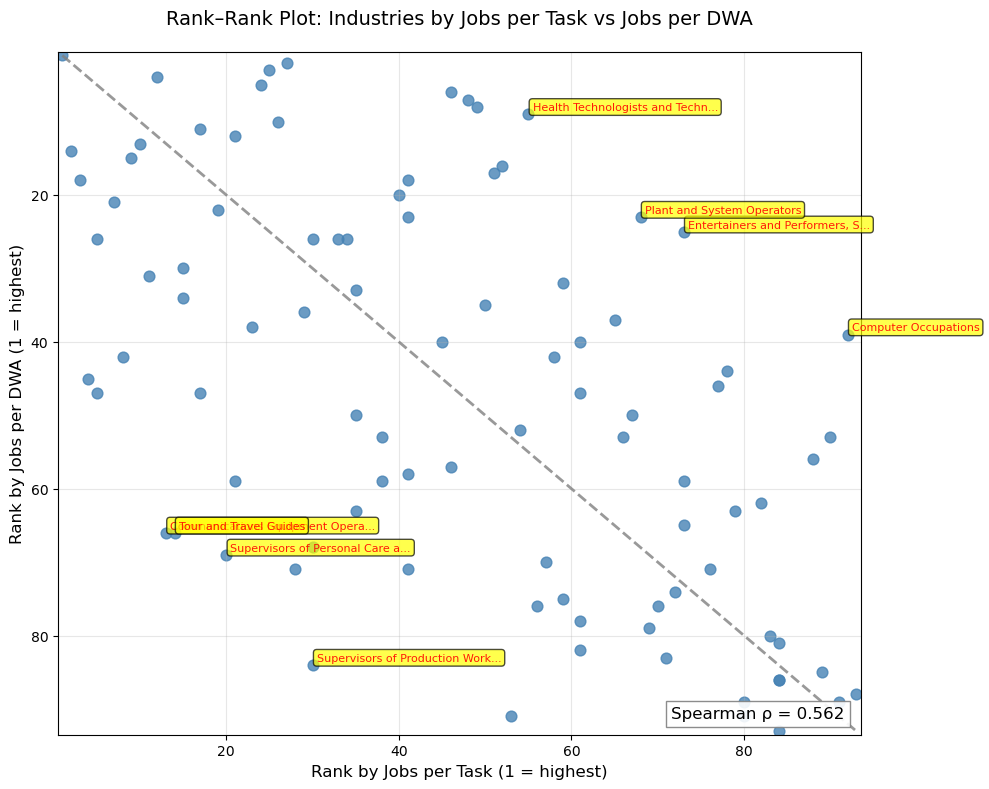

✓ Created rank-rank plot for 93 industries
✓ Rank range: 1 to 93 (as expected)
✓ Spearman correlation: 0.562


In [33]:
# --- Plot the CORRECT rank–rank scatter for Industries ---
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(ranks_industries["rank_task"], ranks_industries["rank_dwa"], color="steelblue", alpha=0.8, s=60)

# Axes labels/titles
ax.set_xlabel("Rank by Jobs per Task (1 = highest)", fontsize=12)
ax.set_ylabel("Rank by Jobs per DWA (1 = highest)", fontsize=12)
ax.set_title("Rank–Rank Plot: Industries by Jobs per Task vs Jobs per DWA", fontsize=14, pad=20)

# 45° reference line (perfect agreement)
max_rank = int(max(ranks_industries["rank_task"].max(), ranks_industries["rank_dwa"].max()))
ax.plot([1, max_rank], [1, max_rank], linestyle="--", color="gray", alpha=0.8, linewidth=2)

# Put best ranks (1) near origin and increase down/right
ax.set_xlim(0.5, max_rank + 0.5)
ax.set_ylim(0.5, max_rank + 0.5)
ax.invert_yaxis()  # top-left is "best-best"

# --- Label biggest mismatches to highlight "top in one ≠ top in the other" ---
N = min(8, len(ranks_industries))
outliers = ranks_industries.sort_values("rank_diff", ascending=False).head(N)
for _, row in outliers.iterrows():
    # Shorten industry names for readability
    ind_short = row["ind_name"][:30] + "..." if len(row["ind_name"]) > 30 else row["ind_name"]
    ax.annotate(ind_short, 
                xy=(row["rank_task"], row["rank_dwa"]),
                xytext=(3, 3), textcoords='offset points',
                fontsize=8, color="red", alpha=0.9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# Calculate and display Spearman rank correlation
spearman_ind = ranks_industries[["rank_task", "rank_dwa"]].corr(method="spearman").iloc[0,1]
ax.text(0.98, 0.02, f"Spearman ρ = {spearman_ind:.3f}",
        transform=ax.transAxes, ha="right", va="bottom",
        fontsize=12, bbox=dict(facecolor="white", edgecolor="gray", alpha=0.9))

# Add grid for better readability
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_plot_path}/rank_rank_industries_jobs_per_task_vs_dwa.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Created rank-rank plot for {len(ranks_industries)} industries")
print(f"✓ Rank range: 1 to {max_rank} (as expected)")
print(f"✓ Spearman correlation: {spearman_ind:.3f}")

In [34]:
# Show top industries by each metric for interpretation
print("=== TOP INDUSTRIES BY JOBS PER TASK ===")
top_task = ranks_industries.nsmallest(10, 'rank_task')[['ind_name', 'jobs_per_task', 'jobs_per_dwa', 'rank_task', 'rank_dwa']]
for i, (_, row) in enumerate(top_task.iterrows(), 1):
    print(f"{i:2d}. {row['ind_name'][:50]:50s} | Task: {row['jobs_per_task']:.3f} (rank {row['rank_task']}) | DWA: {row['jobs_per_dwa']:.3f} (rank {row['rank_dwa']})")

print("\n=== TOP INDUSTRIES BY JOBS PER DWA ===")
top_dwa = ranks_industries.nsmallest(10, 'rank_dwa')[['ind_name', 'jobs_per_task', 'jobs_per_dwa', 'rank_task', 'rank_dwa']]
for i, (_, row) in enumerate(top_dwa.iterrows(), 1):
    print(f"{i:2d}. {row['ind_name'][:50]:50s} | Task: {row['jobs_per_task']:.3f} (rank {row['rank_task']}) | DWA: {row['jobs_per_dwa']:.3f} (rank {row['rank_dwa']})")

print("\n=== BIGGEST RANK DIFFERENCES (labeled on plot) ===")
big_diff = ranks_industries.nlargest(5, 'rank_diff')[['ind_name', 'jobs_per_task', 'jobs_per_dwa', 'rank_task', 'rank_dwa', 'rank_diff']]
for i, (_, row) in enumerate(big_diff.iterrows(), 1):
    print(f"{i}. {row['ind_name'][:50]:50s} | Diff: {row['rank_diff']} | Task rank: {row['rank_task']} | DWA rank: {row['rank_dwa']}")

=== TOP INDUSTRIES BY JOBS PER TASK ===
 1. Legal Support Workers                              | Task: 0.069 (rank 1) | DWA: 0.286 (rank 1)
 2. Forest, Conservation, and Logging Workers          | Task: 0.065 (rank 2) | DWA: 0.148 (rank 14)
 3. Motor Vehicle Operators                            | Task: 0.062 (rank 3) | DWA: 0.140 (rank 18)
 4. Other Protective Service Workers                   | Task: 0.061 (rank 4) | DWA: 0.110 (rank 45)
 5. Baggage Porters, Bellhops, and Concierges          | Task: 0.061 (rank 5) | DWA: 0.105 (rank 47)
 6. Healthcare Diagnosing or Treating Practitioners    | Task: 0.061 (rank 5) | DWA: 0.125 (rank 26)
 7. Assemblers and Fabricators                         | Task: 0.060 (rank 7) | DWA: 0.134 (rank 21)
 8. Helpers, Construction Trades                       | Task: 0.059 (rank 8) | DWA: 0.111 (rank 42)
 9. Material Moving Workers                            | Task: 0.059 (rank 9) | DWA: 0.144 (rank 15)
10. Food Processing Workers                         

In [35]:
onet

,year,occ_code,occ_title,task_id,task,task_type,wa_id,wa_name,dwa_id,dwa_title,...,more_than_monthly,more_than_weekly,daily,several_times_daily,hourly_or_more,task_importance,task_relevance,wa_importance,ind,ind_name
0,2023,11-1011,Chief Executives,8833,"Preside over, or serve on, boards of directors...",Core,NaN,NaN,NaN,NaN,...,42.95,12.69,4.28,3.02,0.00,3.96,72.72,NaN,11-10,Top Executives
1,2023,11-1011,Chief Executives,8835,Establish departmental responsibilities and co...,Core,NaN,NaN,NaN,NaN,...,23.82,19.72,14.05,5.55,0.00,3.96,84.86,NaN,11-10,Top Executives
2,2023,11-1011,Chief Executives,8842,Nominate citizens to boards or commissions.,Supplemental,NaN,NaN,NaN,NaN,...,11.63,0.00,4.48,0.00,0.00,2.81,26.95,NaN,11-10,Top Executives
3,2023,11-1011,Chief Executives,8845,Refer major policy matters to elected represen...,Supplemental,NaN,NaN,NaN,NaN,...,37.97,6.29,0.00,2.60,0.00,3.92,46.48,NaN,11-10,Top Executives
4,2023,11-1011,Chief Executives,8848,Direct or conduct studies or research on issue...,Core,NaN,NaN,NaN,NaN,...,30.50,3.80,4.58,0.20,0.79,3.33,75.11,NaN,11-10,Top Executives
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17940,2023,49-9062,Medical Equipment Repairers,23980,"Inspect, test, or troubleshoot malfunctioning ...",Core,4.A.1.b.2,"Inspecting Equipment, Structures, or Materials",4.A.1.b.2.I07.D20,"Inspect mechanical equipment to locate damage,...",...,6.25,18.57,47.52,14.27,12.62,4.55,99.61,4.20,49-90,"Other Installation, Maintenance, and Repair Oc..."
17941,2023,49-9062,Medical Equipment Repairers,23981,Install medical equipment.,Core,4.A.3.a.2,Handling and Moving Objects,4.A.3.a.2.I46.D01,Install equipment attachments or components.,...,39.87,21.52,4.49,0.00,2.96,4.14,84.12,3.59,49-90,"Other Installation, Maintenance, and Repair Oc..."
17942,2023,51-6061,Textile Bleaching and Dyeing Machine Operators...,23982,"Weigh ingredients, such as dye, to be mixed to...",Core,4.A.1.b.3,Estimating the Quantifiable Characteristics of...,4.A.1.b.3.I01.D10,Measure ingredients or substances to be used i...,...,5.70,8.59,35.29,20.00,29.01,4.64,68.72,2.88,51-60,"Textile, Apparel, and Furnishings Workers"
17943,2023,51-9023,"Mixing and Blending Machine Setters, Operators...",23983,Clean work areas.,Core,4.A.3.a.1,Performing General Physical Activities,4.A.3.a.1.I03.D05,Clean work areas.,...,0.00,0.57,76.15,6.12,17.16,4.26,100.00,4.22,51-90,Other Production Occupations


In [37]:
soc = pd.read_csv('/Users/peymanshahidi/MIT Dropbox/Peyman Shahidi/GitHub/rubin/data/SOC_Structure.csv')
soc.nunique()

Major Group                      23
Minor Group                      98
Broad Occupation                459
Detailed Occupation             867
Detailed O*NET-SOC              149
SOC or O*NET-SOC 2019 Title    1333
dtype: int64